### Bot Detection using Digital DNA Compression

# Modifications by TS
- changed datasets
- did NOT use Twibot-20 test-training dataset split

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
import random
import sys
import time
import zlib

In [4]:
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from scipy.stats import ttest_1samp

<hr>

### Digital DNA

Model account behaviour by defining the following alphabet, of cardinality N = 3,

$B^3_{type} = {\{A, C, T\}}$

A $\leftarrow$ tweet,

C $\leftarrow$ reply,

T $\leftarrow$ retweet

<hr>

#### Datasets

User profile data.

In [5]:
### Users

# Genuine accounts.
gen_train = pd.read_csv('./Twibot-20/twibot_trainset_accountdata_genuineuser.csv')
gen_test = pd.read_csv('./Twibot-20/twibot_testset_accountdata_genuineuser.csv')


# Bot accounts.
bot_train = pd.read_csv('./Twibot-20/twibot_trainset_accountdata_botuser.csv')
bot_test = pd.read_csv('./Twibot-20/twibot_testset_accountdata_botuser.csv')

all_bot_accounts = pd.concat([bot_train, bot_test])
all_genuine_accounts = pd.concat([gen_train, gen_test])

Tweets.

In [6]:
### Tweets

# Genuine accounts.
gen_train_tweets = pd.read_csv('./Twibot-20/twibot_trainset_tweetdata_genuineuser.csv')
gen_test_tweets = pd.read_csv('./Twibot-20/twibot_testset_tweetdata_genuineuser.csv')


# Bot accounts.
bot_train_tweets = pd.read_csv('./Twibot-20/twibot_trainset_tweetdata_botuser.csv')
bot_test_tweets = pd.read_csv('./Twibot-20/twibot_testset_tweetdata_botuser.csv')

<hr>

#### Digital DNA.

In [7]:
def create_dna_from_tweets(tweets_df):
    '''For each user id in tweets_df return a digital DNA string based on posting behaviour.'''
    
    # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    tweets_df.loc[:, 'DNA'] = np.where(retweets, 'C', np.where(replies, 'T', 'A'))

    # Sort tweets by timestamp..
    tweets_df = tweets_df[['user_id', 'timestamp', 'DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])

    # Create digital DNA string for each user account.
    dna = tweets_df.groupby(by=['user_id'])['DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [8]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'dna': dna,
                           'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

<hr>

Create DNA strings based on behaviour activity for each account.

In [9]:
gen_train_dna = create_dna_from_tweets(gen_train_tweets)
gen_test_dna = create_dna_from_tweets(gen_test_tweets)


bot_train_dna = create_dna_from_tweets(bot_train_tweets)
bot_test_dna = create_dna_from_tweets(bot_test_tweets)


Compression on digital DNA strings.

In [10]:
gen_train_dna = compress_dna_df(gen_train_dna)
gen_test_dna = compress_dna_df(gen_test_dna)

bot_train_dna = compress_dna_df(bot_train_dna)
bot_test_dna = compress_dna_df(bot_test_dna)

bot_dna = pd.concat([bot_train_dna, bot_test_dna])
gen_dna = pd.concat([gen_train_dna, gen_test_dna])

<hr>

#### Visualise compression facts for accounts.

In [11]:
# Add a column for account type to the dataframes.
gen_dna['Account Type'] = 'Genuine'
bot_dna['Account Type'] = 'Bot'

# Combine all samples into a single dataframe.
all_dna = pd.concat([gen_dna, bot_dna])

In [12]:
all_dna.sample(5)

dna  \
user_id                                                                 
41160276            AAAAAAAACAAAAAATAAAACACAAAAAAAAAACAAACAAAAAAAA...   
1314883734          AACAAATTCATCAACCAACAACCTAACCAAAAAACACCACAAATCA...   
66347007            TCCCCATCCCCCAACCCATTTTCCTACCCTCTATTTACCTAACCCC...   
885958969499541505  CTCCTACCTCCCCCCCCCCTTCACCCCCCCCTTTCCCCCTCACTCC...   
23482952            ACAAAAAAAAAAAACAAAAAAAAAACAAAAAAAAAAAAAAAAAAAA...   

                    original_dna_size  compressed_dna_size  compression_ratio  \
user_id                                                                         
41160276                          233                   83           2.807229   
1314883734                        233                  113           2.061947   
66347007                          229                  108           2.120370   
885958969499541505                233                   90           2.588889   
23482952                          233                   59           3.949153   

                   Account Type  
user_id                          
41160276                Genuine  
1314883734              Genuine  
66347007                Genuine  
885958969499541505          Bot  
23482952                Genuine

##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

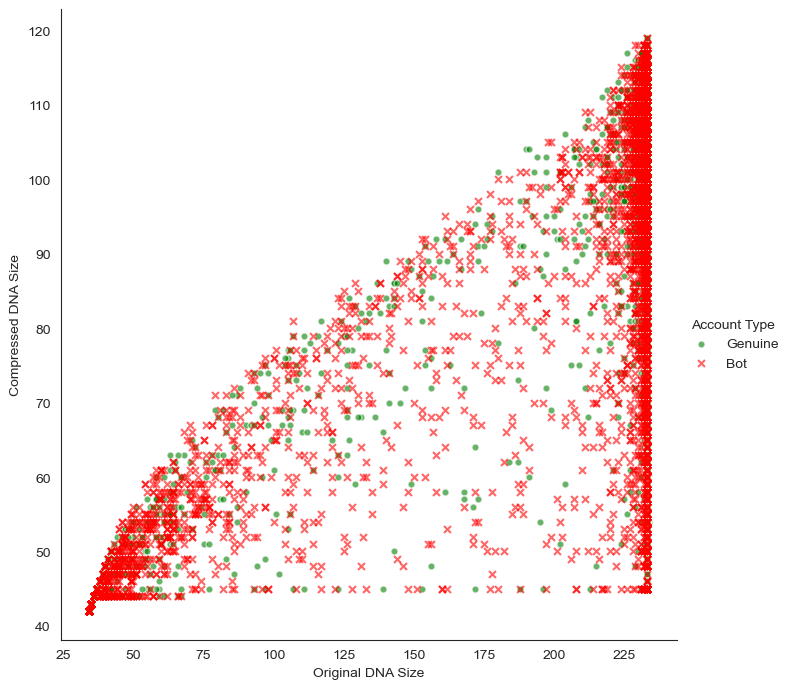

In [13]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

##### Plot of DNA Size vs. Compression Ratio.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

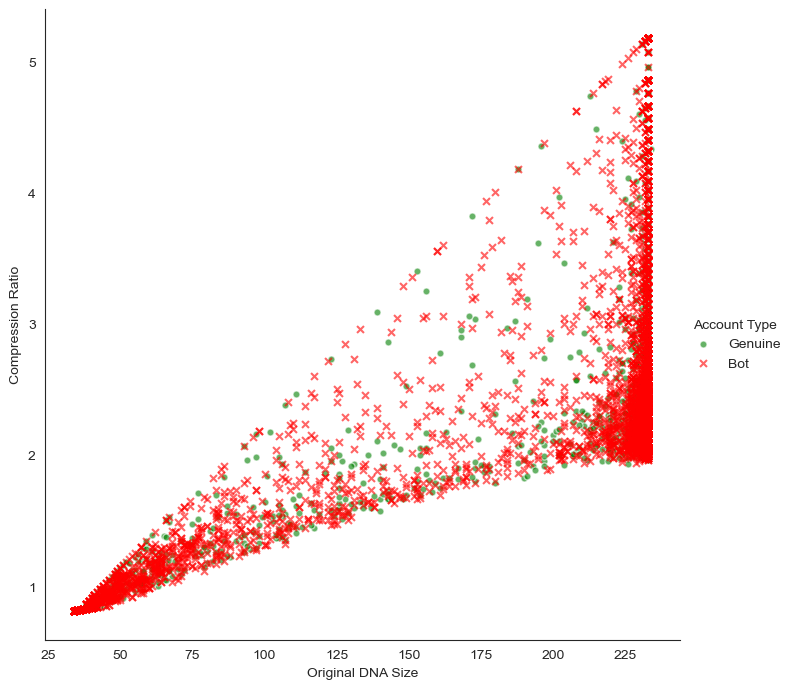

In [14]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

##### Historgram for Compression Ratio

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

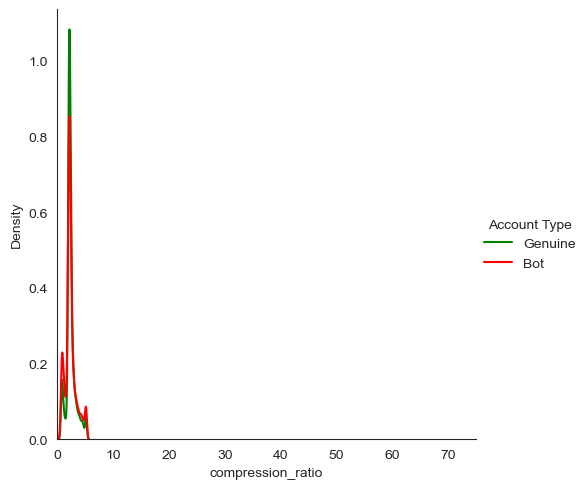

In [15]:
g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=5)
g.set(xlim=(0, 75))
g.map(sns.kdeplot, 'compression_ratio')
g.add_legend()

<hr>

Evaluation Metrics
1. Accuracy
1. Precision
1. Recall
1. F1 Score
1. Specificity
1. MCC

In [16]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

<hr>

In [17]:
def train_predict_evaluate(dna, features, test_size=0.5):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Logistic Regression classifier with default parameters.
    classifier = LogisticRegression()

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

<hr>

Results for k-common substring

In [18]:
k_common_substring_1 = pd.DataFrame({'Supervised': [0.977, 0.977, 0.955, 0.982, 0.977, 0.981],
                                     'Unsupervised': [0.976, 0.977, 0.952, 0.982, 0.972, 0.981]}, 
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])


In [19]:
k_common_substring_2 = pd.DataFrame({'Supervised': [0.970, 0.970, 0.940, 0.978, 0.961, 0.979], 
                                     'Unsupervised': [0.929, 0.923, 0.867, 1.000, 0.858, 1.000]},
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])

<hr>

## Trial

In [20]:
# # Add a column for label to the dataframes.
gen_dna['label'] = 0
bot_dna['label'] = 1
all_dna = pd.concat([gen_dna, bot_dna])

There are some accounts for which there are no tweets, set an empty string as the DNA sequence for such accounts.

In [21]:
sys.getsizeof(''.encode('utf-8'))   # size in bytes of empty string

33

In [22]:
sys.getsizeof(zlib.compress(''.encode('utf-8')))    # size in bytes of compressed empty string

41

In [23]:
# compression ratio for empty string
sys.getsizeof(''.encode('utf-8')) / sys.getsizeof(zlib.compress(''.encode('utf-8')))

0.8048780487804879

In [24]:
# include genuine users without tweets
genuine_with_no_tweets = all_genuine_accounts[~all_genuine_accounts['id'].isin(gen_dna.index)]

genuine_with_no_tweets_dna = pd.DataFrame({'id': genuine_with_no_tweets['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

genuine_with_no_tweets_dna = genuine_with_no_tweets_dna.set_index('id')

genuine_dna = pd.concat([gen_dna, genuine_with_no_tweets_dna])

# include botuser users without tweets
botuser_with_no_tweets = all_bot_accounts[~all_bot_accounts['id'].isin(bot_dna.index)]

botuser_with_no_tweets_dna = pd.DataFrame({'id': botuser_with_no_tweets['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 1})

botuser_with_no_tweets_dna = botuser_with_no_tweets_dna.set_index('id')

botuser_dna = pd.concat([bot_dna, botuser_with_no_tweets_dna])

# Combine test set 1 accounts into a single dataframe.
dna = pd.concat([genuine_dna , botuser_dna ])

In [25]:
len(dna)

9461

In [26]:
dna.sample(5)

dna  \
1141829212447354881  TAAATTAATAAAAAAAAACAAAATAACTATAAATTCAAAAATAAAA...   
1166524855988080641  AAACCAAAAATAAATACCCAAATCTCATTTCATTCCCTTATTTCAT...   
82303907             AATTAAAAAATAAAAAATCAAAAAAATTAAATTCAAAACAAAAAAA...   
17609668             CCCCCCCACCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...   
3107493797           AAAAAAAAACAAAAAAACTCAAAAAAAAAAAAAAAACAAAAAAACA...   

                     original_dna_size  compressed_dna_size  \
1141829212447354881                232                  108   
1166524855988080641                233                  112   
82303907                           233                  104   
17609668                           231                   96   
3107493797                          87                   54   

                     compression_ratio Account Type  label  
1141829212447354881           2.148148      Genuine      0  
1166524855988080641           2.080357      Genuine      0  
82303907                      2.240385          Bot      1  
17609668                      2.406250      Genuine      0  
3107493797                    1.611111      Genuine      0

1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [27]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna, ['original_dna_size', 'compressed_dna_size'])])

# Compute average scores for each metric
results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

t-supervised  t-unsupervised  p-supervised  p-unsupervised  \
Metric                                                                    
Accuracy       -2328.5493      -2322.9882           0.0             0.0   
F1 Score        -533.2443       -533.2443           0.0             0.0   
MCC            -1433.2424      -1428.4928           0.0             0.0   
Precision      -1192.1716      -1192.1716           0.0             0.0   
Recall           -48.7175        -46.5934           0.0             0.0   
Specificity     -278.0508       -278.0508           0.0             0.0   

                 Mean        SD  k-supervised  k-unsupervised  
Metric                                                         
Accuracy     0.558273  0.005687         0.977           0.976  
F1 Score     0.684569  0.017342         0.977           0.977  
MCC          0.049726  0.019974         0.955           0.952  
Precision    0.570009  0.010928         0.982           0.982  
Recall       0.862327  0.074435         0.977           0.972  
Specificity  0.174924  0.091675         0.981           0.981

2. Logistic Regression with Original DNA Size + Compression Ratio

In [28]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

t-supervised  t-unsupervised  p-supervised  p-unsupervised  \
Metric                                                                    
Accuracy       -2117.0614      -2111.9890           0.0             0.0   
F1 Score        -391.0340       -391.0340           0.0             0.0   
MCC            -1002.5451       -999.1976           0.0             0.0   
Precision       -871.3520       -871.3520           0.0             0.0   
Recall           -42.0254        -40.4346           0.0             0.0   
Specificity     -196.3020       -196.3020           0.0             0.0   

                 Mean        SD  k-supervised  k-unsupervised  
Metric                                                         
Accuracy     0.559629  0.006234         0.977           0.976  
F1 Score     0.679888  0.024027         0.977           0.977  
MCC          0.056520  0.028340         0.955           0.952  
Precision    0.573520  0.014824         0.982           0.982  
Recall       0.844905  0.099397         0.977           0.972  
Specificity  0.200661  0.125707         0.981           0.981

In [29]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.558 & 0.570 & 0.862 & 0.685 & 0.050 & 0.175 \\
String Compression - Compression Ratio & 0.560 & 0.574 & 0.845 & 0.680 & 0.057 & 0.201 \\


##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#3

In [30]:
dna

dna  \
12                   CTTCCCCCCCCCCCCATTACTCCCCCATACTTCCCTCACCCAAACC...   
1605                 AAAAAAAAAAATAAAAAAAAAAAACTATTTTTAACCAAACCCTTCA...   
10350                CATATTATTTTTTCTATTTTTTAATCTCTTTTTTTTTTTTTTTTAC...   
12830                TATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
76093                CCACCACAACCCCCCCTATACCCTCCCCCAAAAAATAACCACCCTA...   
...                                                                ...   
1298281349736849408                                                NaN   
797609436357525504                                                 NaN   
1299719511269167105                                                NaN   
1300426269079875585                                                NaN   
2480232313                                                         NaN   

                     original_dna_size  compressed_dna_size  \
12                                 232                  110   
1605                               233                  103   
10350                              233                  100   
12830                              233                   64   
76093                              232                  110   
...                                ...                  ...   
1298281349736849408                 33                   41   
797609436357525504                  33                   41   
1299719511269167105                 33                   41   
1300426269079875585                 33                   41   
2480232313                          33                   41   

                     compression_ratio Account Type  label  
12                            2.109091      Genuine      0  
1605                          2.262136      Genuine      0  
10350                         2.330000      Genuine      0  
12830                         3.640625      Genuine      0  
76093                         2.109091      Genuine      0  
...                                ...          ...    ...  
1298281349736849408           0.800000          NaN      1  
797609436357525504            0.800000          NaN      1  
1299719511269167105           0.800000          NaN      1  
1300426269079875585           0.800000          NaN      1  
2480232313                    0.800000          NaN      1  

[9461 rows x 6 columns]

In [31]:
dna_all = dna.drop('Account Type', axis=1)
dna_all = dna_all.rename({'label': 'Account Type'}, axis=1)
dna_all['Account Type'] = np.where(dna_all['Account Type'] == 0, 'Genuine User', 'Bot Account')

sns.set(style='white', font='Source Sans Pro')

pal = {
    'Genuine User': sns.color_palette('Dark2')[0],
    'Bot Account':  sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(dna_all, hue='Account Type', 
                  palette=pal, height=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=100, alpha=0.85, edgecolor="white")
# g.add_legend()
plt.legend(loc='upper left', frameon=False)
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')
g.savefig('dna-scatter-1_Twibot-20-orginial-method.pdf')

##### Plot of DNA Size vs. Compression Ratio.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#3

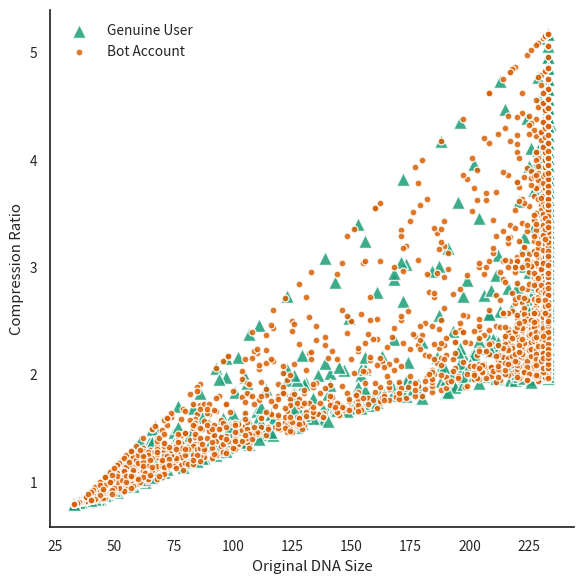

In [32]:
dna_all = dna.drop('Account Type', axis=1)
dna_all = dna_all.rename({'label': 'Account Type'}, axis=1)
dna_all['Account Type'] = np.where(dna_all['Account Type'] == 0, 'Genuine User', 'Bot Account')

sns.set(style='white', font='Source Sans Pro')

pal = {
    'Genuine User': sns.color_palette('Dark2')[0],
    'Bot Account':  sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(dna_all, hue='Account Type', 
                  palette=pal, height=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=100, alpha=0.85, edgecolor="white")
# g.add_legend()
plt.legend(loc='upper left', frameon=False)
g.set_axis_labels('Original DNA Size', 'Compression Ratio')
g.savefig('dna-scatter-2_Twibot-20-orginial-method.pdf')

<hr>

In [33]:
# markers = {'Genuine': '^', 'Bot': '+'}

# ax = sns.scatterplot(data=dna_all, x='original_dna_size', y='compressed_dna_size', s=50,
#                 hue='Account Type', palette=pal, style='Account Type', alpha=0.7)

# ax.set_xlabel('Original DNA Size')
# ax.set_ylabel('Compressed DNA Size')